# miniFE
MiniFE is an proxy application for unstructured implicit finite element codes. It is similar to HPCCG and pHPCCG but provides a much more complete vertical covering of the steps in this class of applications. MiniFE also provides support for computation on multicore nodes, including pthreads and Intel Threading Building Blocks (TBB) for homogeneous multicore and CUDA for GPUs. Like HPCCG and pHPCCG, MiniFE is intended to be the "best approximation to an unstructured implicit finite element or finite volume application, but in 8000 lines or fewer."

---
## Parameters
```
Compiler = 'clang 5.0.1'

Build_Flags = '-g -O3 -march=native -fopenmp -DMINIFE_SCALAR=double -DMINIFE_LOCAL_ORDINAL=int -DMINIFE_GLOBAL_ORDINAL=int -DMINIFE_CSR_MATRIX -DMINIFE_INFO=1 -DMINIFE_KERNELS=0'

Run_Parameters = '-nx 256 -ny 256 -nz 256'
```

### Compiler Specific Pragmas
`#pragma loop_count(15)`  -- intel

---
## Scaling

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

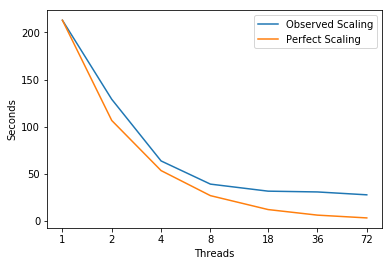

In [2]:
# Plot Measurements
Threads = [1,2,4,8,18,36,72]
fig, ax = plt.subplots(); ax.set_xscale('log', basex=2); ax.set_xticks(Threads)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.plot(Threads,[213.0, 129.0, 63.5, 38.875, 31.38888888888889, 30.555555555555557, 27.5],
        label='Observed Scaling')
ax.plot(Threads, [213.0, 106.5, 53.25, 26.625, 11.833333333333334, 5.916666666666667, 2.9583333333333335],
        label='Perfect Scaling')
ax.legend(); ax.set_xlabel('Threads'); ax.set_ylabel('Seconds')
plt.show()

assembling FE data, imposing Dirichlet BC both scale great, but the CG solver stops scaling at 8 threads and takes over the run time.   
**Compiler Specific "#pragma loop_count(15)" in matvec in cg_solve**

|Section|1 Thread|8 Threads|72 Threads|
|:---|:---:|:---:|:---:|
|CG Solver - matvec | 124.1 sec | 20.3 sec | 18.3 sec|
| Other | 95.6 sec | 19.7 sec | 8.7 sec|

---
## Roofline - Intel Haswell - 72 Threads - 36 Cores - 2 Sockets - 2301.0 Mhz
| GB/sec | L1 B/W | L2 B/W | L3 B/W | DRAM B/W |
|:---------|:------:|:------:|:------:|:--------:|
|**72 Threads**  | 2399.9  |  784.0  |  564.8  |   60.4  |

## matvec_std( )
```c++
489 //------------------------------------------------------------------------
490 //Compute matrix vector product y = A*x where:
491 //
492 // A - input matrix
493 // x - input vector
494 // y - result vector
495 //
496 #if defined(MINIFE_CSR_MATRIX)
497 template<typename MatrixType,
498          typename VectorType>
499 struct matvec_std {
500 void operator()(MatrixType& A,
501             VectorType& x,
502             VectorType& y)
503 {
504         exchange_externals(A, x);
505 
506         typedef typename MatrixType::ScalarType ScalarType;
507         typedef typename MatrixType::GlobalOrdinalType GlobalOrdinalType;
508         typedef typename MatrixType::LocalOrdinalType LocalOrdinalType;
509 
510         const MINIFE_GLOBAL_ORDINAL rows_size     = A.rows.size();
511         const LocalOrdinalType* const Arowoffsets = &A.row_offsets[0];
512         const GlobalOrdinalType* const Acols      = &A.packed_cols[0];
513         const ScalarType* const Acoefs            = &A.packed_coefs[0];
514         const ScalarType* const xcoefs            = &x.coefs[0];
515         ScalarType* ycoefs                        = &y.coefs[0];
516         const ScalarType beta                     = 0;
517 
```
| .omp_outlined..143 | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 72                 |  41.2 %   |       0.49          |         8.2% |         68.9% |      9.6% |                0.27     |       15.1% |       14.4%  |      12.9%    |

```c++
518         #pragma omp parallel for
519         for(MINIFE_GLOBAL_ORDINAL row = 0; row < rows_size; ++row) {
520                 const MINIFE_GLOBAL_ORDINAL row_start = Arowoffsets[row];
521                 const MINIFE_GLOBAL_ORDINAL row_end   = Arowoffsets[row+1];
522 
523                 MINIFE_SCALAR sum = 0;
524 
525                 #pragma loop_count(15)
526                 for(MINIFE_GLOBAL_ORDINAL i = row_start; i < row_end; ++i) {
527                         sum += Acoefs[i] * xcoefs[Acols[i]];
528                 }
529 
530                 ycoefs[row] = sum;
531         }
532 }
533 };
```

## Vector.hpp
## Constructor
```c++
 36 template<typename Scalar,
 37          typename LocalOrdinal,
 38          typename GlobalOrdinal>
 39 struct Vector {
 40   typedef Scalar ScalarType;
 41   typedef LocalOrdinal LocalOrdinalType;
 42   typedef GlobalOrdinal GlobalOrdinalType;
 43 
 44   Vector(GlobalOrdinal startIdx, LocalOrdinal local_sz)
 45    : startIndex(startIdx),
 46      local_size(local_sz),
 47      coefs(local_size)
 48   {
 ```
 | .omp_outlined..109 | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 72                 |  10.7 %   |    0.00016          |         4.2% |          4.6% |      0.0% |                0.00     |        0.0% |        0.0%  |       0.0%    |

 ```c++
 49     #pragma omp parallel for
 50     for(MINIFE_LOCAL_ORDINAL i=0; i < local_size; ++i) {
 51         coefs[i] = 0;
 52     }
 53   }
 54 
 55   ~Vector()
 56   {
 57   }
 58 
 59   GlobalOrdinal startIndex;
 60   LocalOrdinal local_size;
 61   std::vector<Scalar> coefs;
 62 };
```

## Daxpby
```c++
186 template<typename VectorType>
187 void
188   daxpby(const MINIFE_SCALAR alpha,
189         const VectorType& x,
190         const MINIFE_SCALAR beta,
191         VectorType& y)
192 {
193 
194   const MINIFE_LOCAL_ORDINAL n = MINIFE_MIN(x.coefs.size(), y.coefs.size());
195   const MINIFE_SCALAR*  xcoefs = &x.coefs[0];
196         MINIFE_SCALAR*  ycoefs = &y.coefs[0];
197 
198   if(alpha == 1.0 && beta == 1.0) {
199           #pragma omp parallel for
200           for(int i = 0; i < n; ++i) {
201             ycoefs[i] += xcoefs[i];
202           }
203   } else if (beta == 1.0) {
```
| .omp_outlined..137 | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 72                 |  4.9 %   |      0.055          |        39.1% |         75.0% |     28.3% |                0.02     |        9.5% |        9.9%  |      26.1%    |
```c++
204           #pragma omp parallel for
205           for(int i = 0; i < n; ++i) {
206             ycoefs[i] += alpha * xcoefs[i];
207           }
208   } else if (alpha == 1.0) {
```
| .omp_outlined..138 | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 72                 |  2.2 %   |      0.055          |        37.7% |         76.3% |     27.1% |                0.02     |       10.9% |       11.5%  |      29.2%    |
```c
209           #pragma omp parallel for
210           for(int i = 0; i < n; ++i) {
211             ycoefs[i] = xcoefs[i] + beta * ycoefs[i];
212           }
213   } else if (beta == 0.0) {
214           #pragma omp parallel for
215           for(int i = 0; i < n; ++i) {
216             ycoefs[i] = alpha * xcoefs[i];
217           }
218   } else {
219           #pragma omp parallel for
220           for(int i = 0; i < n; ++i) {
221             ycoefs[i] = alpha * xcoefs[i] + beta * ycoefs[i];
222           }
223   }
224 
225 }
```

## Dot
```c++
227 //-----------------------------------------------------------
228 //Compute the dot product of two vectors where:
229 //
230 // x,y - input vectors
231 //
232 // result - return-value
233 //
234 template<typename Vector>
235 typename TypeTraits<typename Vector::ScalarType>::magnitude_type
236   dot(const Vector& x,
237       const Vector& y)
238 {
239   const MINIFE_LOCAL_ORDINAL n = x.coefs.size();
240 
241   typedef typename Vector::ScalarType Scalar;
242   typedef typename TypeTraits<typename Vector::ScalarType>::magnitude_type magnitude;
243 
244   const Scalar*  xcoefs = &x.coefs[0];
245   const Scalar*  ycoefs = &y.coefs[0];
246   MINIFE_SCALAR result = 0;
247 
```
| .omp_outlined..141 | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 72                 |  2.2 %   |       0.64          |         5.7% |         70.1% |     12.7% |                0.22     |       10.5% |       10.2%  |      12.1%    |
```c++
248   #pragma omp parallel for reduction(+:result)
249   for(int i=0; i<n; ++i) {
250     result += xcoefs[i] * ycoefs[i];
251   }
252 
253 #ifdef HAVE_MPI
254   magnitude local_dot = result, global_dot = 0;
255   MPI_Datatype mpi_dtype = TypeTraits<magnitude>::mpi_type();
256   MPI_Allreduce(&local_dot, &global_dot, 1, mpi_dtype, MPI_SUM, MPI_COMM_WORLD);
257   return global_dot;
258 #else
259   return result;
260 #endif
261 }
```

## Dot_r2
```c++
263 template<typename Vector>
264 typename TypeTraits<typename Vector::ScalarType>::magnitude_type
265   dot_r2(const Vector& x)
266 {
      // { Debug Code }
272 
273   const MINIFE_LOCAL_ORDINAL n = x.coefs.size();
274 
      // { Debug Code }
281 
282   typedef typename Vector::ScalarType Scalar;
283   typedef typename TypeTraits<typename Vector::ScalarType>::magnitude_type magnitude;
284 
285   const MINIFE_SCALAR*  xcoefs = &x.coefs[0];
286   MINIFE_SCALAR result = 0;
287 
```
| .omp_outlined..134 | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 72                 |  1.7 %   |       0.73          |         2.6% |         73.0% |     22.1% |                0.27     |        6.5% |        6.6%  |      13.6%    |
```c++
288   #pragma omp parallel for reduction(+:result)
289   for(int i=0; i<n; ++i) {
290     result += xcoefs[i] * xcoefs[i];
291   }
292 
293 #ifdef HAVE_MPI
294   magnitude local_dot = result, global_dot = 0;
295   MPI_Datatype mpi_dtype = TypeTraits<magnitude>::mpi_type();
296   MPI_Allreduce(&local_dot, &global_dot, 1, mpi_dtype, MPI_SUM, MPI_COMM_WORLD);
297 
      // { Debug Code }
301 
302   return global_dot;
303 #else
      // { Debug Code }
307   return result;
308 #endif
309 }
```

## perform_element_loop
```c++
 46 template<typename GlobalOrdinal,
 47          typename MatrixType, typename VectorType>
 48 void
 49 perform_element_loop(const simple_mesh_description<GlobalOrdinal>& mesh,
 50                      const Box& local_elem_box,
 51                      MatrixType& A, VectorType& b,
 52                      Parameters& /*params*/)
 53 {
 54   typedef typename MatrixType::ScalarType Scalar;
 55 
 56   int global_elems_x = mesh.global_box[0][1];
 57   int global_elems_y = mesh.global_box[1][1];
 58   int global_elems_z = mesh.global_box[2][1];
 59 
 60   //We will iterate the local-element-box (local portion of the mesh), and
 61   //get element-IDs in preparation for later assembling the FE operators
 62   //into the global sparse linear-system.
 63 
 64   GlobalOrdinal num_elems = get_num_ids<GlobalOrdinal>(local_elem_box);
 65   std::vector<GlobalOrdinal> elemIDs(num_elems);
 66 
 67   BoxIterator iter = BoxIterator::begin(local_elem_box);
 68   BoxIterator end  = BoxIterator::end(local_elem_box);
 69 
 70   for(size_t i=0; iter != end; ++iter, ++i) {
 71     elemIDs[i] = get_id<GlobalOrdinal>(global_elems_x, global_elems_y, global_elems_z,
 72                                        iter.x, iter.y, iter.z);
 73   }
 74 
 75   timer_type t_gn = 0, t_ce = 0, t_si = 0;
 76   timer_type t0 = 0;
 77 
 78   const MINIFE_GLOBAL_ORDINAL elemID_size = elemIDs.size();
 79 
 ```
 | .omp_outlined..110 | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 72                 |  3.8 %   |        2.3          |         0.7% |         16.5% |      0.0% |                0.61     |        3.1% |        0.7%  |       0.0%    |
 ```c++
 80   #pragma omp parallel for shared (elemIDs)
 81   for(MINIFE_GLOBAL_ORDINAL i=0; i < elemID_size; ++i) {
 82     ElemData<GlobalOrdinal,Scalar> elem_data;
 83     compute_gradient_values(elem_data.grad_vals);
 84 
 85     get_elem_nodes_and_coords(mesh, elemIDs[i], elem_data);
 86     compute_element_matrix_and_vector(elem_data);
 87     sum_into_global_linear_system(elem_data, A, b);
 88   }
 89 
 90 }
```

## Impose_dirichlet
```c++
432 template<typename MatrixType,
433          typename VectorType>
434 void
435 impose_dirichlet(typename MatrixType::ScalarType prescribed_value,
436                     MatrixType& A,
437                     VectorType& b,
438                     int global_nx,
439                     int global_ny,
440                     int global_nz,
441                     const std::set<typename MatrixType::GlobalOrdinalType>& bc_rows)
442 {
443   typedef typename MatrixType::GlobalOrdinalType GlobalOrdinal;
444   typedef typename MatrixType::LocalOrdinalType LocalOrdinal;
445   typedef typename MatrixType::ScalarType Scalar;
446 
447   GlobalOrdinal first_local_row = A.rows.size()>0 ? A.rows[0] : 0;
448   GlobalOrdinal last_local_row  = A.rows.size()>0 ? A.rows[A.rows.size()-1] : -1;
449 
450   typename std::set<GlobalOrdinal>::const_iterator
451     bc_iter = bc_rows.begin(), bc_end = bc_rows.end();
452   for(; bc_iter!=bc_end; ++bc_iter) {
453     GlobalOrdinal row = *bc_iter;
454     if (row >= first_local_row && row <= last_local_row) {
455       size_t local_row = row - first_local_row;
456       b.coefs[local_row] = prescribed_value;
457       zero_row_and_put_1_on_diagonal(A, row);
458     }
459   }
460 
461   const int ROW_COUNT = A.rows.size();
462 
```
| .omp_outlined..112 | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 72                 |  4.7 %   |        1.0          |        10.3% |          0.3% |      0.0% |                0.28     |       20.2% |        0.1%  |       0.0%    |
```c++
463   #pragma omp parallel for
464   for(MINIFE_GLOBAL_ORDINAL i=0; i < ROW_COUNT; ++i) {
465     GlobalOrdinal row = A.rows[i];
466 
467     if (bc_rows.find(row) != bc_rows.end()) continue;
468 
469     size_t row_length = 0;
470     GlobalOrdinal* cols = NULL;
471     Scalar* coefs = NULL;
472     A.get_row_pointers(row, row_length, cols, coefs);
473 
474     Scalar sum = 0;
475     for(size_t j=0; j<row_length; ++j) {
476       if (bc_rows.find(cols[j]) != bc_rows.end()) {
477         sum += coefs[j];
478         coefs[j] = 0;
479       }
480     }
481 
482     #pragma omp atomic
483     b.coefs[i] -= sum*prescribed_value;
484   }
485 }
```